# Model FREEE Methods

# 03 — TD(0): uczenie „w trakcie” (bootstrapping)

W tym rozdziale przechodzimy z **MC** (pełne epizody) do **TD(0)** (update po każdym kroku).

### Co estymujemy w obu metodach?

Dla ustalonej polityki $\pi$ celem jest ta sama funkcja wartości:

$$
V^\pi(s)=\mathbb{E}_\pi[G_t\mid S_t=s],
$$

gdzie zwrot (return) to:

$$
G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots
$$

Ta definicja prowadzi do równania Bellmana (expectation):

$$
V^\pi(s)=\mathbb{E}_\pi\big[r_{t+1}+\gamma V^\pi(S_{t+1})\mid S_t=s\big].
$$

### MC vs TD(0) — *różni się target*

- **MC target (bez bootstrappingu):** $\hat G_t^{\text{MC}} = G_t$  
  update dopiero po poznaniu całego epizodu:
  $$
  V(s)\leftarrow V(s)+\alpha\big(\hat G_t^{\text{MC}}-V(s)\big).
  $$

- **TD(0) target (bootstrapping):** $\hat G_t^{\text{TD}} = r_{t+1}+\gamma V(S_{t+1})$  
  update natychmiast po kroku:
  $$
  V(S_t)\leftarrow V(S_t)+\alpha\big(\hat G_t^{\text{TD}}-V(S_t)\big).
  $$

**Terminale:** jeśli `done=True`, przyjmujemy $V(S_{t+1})=0$, więc $\hat G_t^{\text{TD}}=r_{t+1}$.

**Warto zwrócić uwagę:**  
- TD ma zwykle **mniejszą wariancję** niż MC (bo nie czeka do końca),  
- ale wprowadza **bias** (bo ufa własnym przewidywaniom).

W tym notebooku:
1) TD(0) prediction i porównanie do MC (ten sam budżet epizodów),  
2) krótki preview: SARSA vs Q-learning.


In [22]:
import os, sys
# dodaj katalog główny repo do ścieżki importów
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

import numpy as np
import matplotlib.pyplot as plt

In [23]:
from envs.wrappers import get_spec
from envs.frozenlake import FROZENLAKE_MAPS, build_frozenlake_P, find_start_state, PModelEnv

from algorithms.td import td0_prediction, sarsa, q_learning
from algorithms.mc import mc_prediction
from algorithms.dp import policy_evaluation
from algorithms.utils import plot_value_heatmap, plot_learning_curve

## Wybór środowiska

In [24]:
# FrozenLake-only (trzymamy spójność z 00/01/02)
MAP_NAME = "4x4"   # "4x4" albo "8x8"
SLIPPERY = True    # TODO (student): porównaj False vs True

desc = FROZENLAKE_MAPS[MAP_NAME]
P, nS, nA, nrow, ncol, desc_arr = build_frozenlake_P(desc, is_slippery=SLIPPERY)
s0 = find_start_state(desc_arr)  # rozwiązanie
env = PModelEnv(P, start_state=s0, seed=0, desc=desc_arr)
env.nrow, env.ncol, env.desc = nrow, ncol, desc_arr

spec = get_spec(env, gamma=0.99)
print("FrozenLake map:")
print("\n".join("".join(row) for row in spec.desc))
spec


FrozenLake map:
SFFF
FHFH
FFFH
HFFG


DiscreteEnvSpec(nS=16, nA=4, shape=(4, 4), terminals={5, 7, 11, 12, 15}, gamma=0.99, desc=array([['S', 'F', 'F', 'F'],
       ['F', 'H', 'F', 'H'],
       ['F', 'F', 'F', 'H'],
       ['H', 'F', 'F', 'G']], dtype='<U1'))

### Przypomnienie (w pigułce): MC vs TD(0)

| Metoda | Kiedy update? | Target | Bootstrapping? | Konsekwencja |
|---|---:|---|---:|---|
| MC | po epizodzie | $G_t$ | nie | mały bias, duża wariancja |
| TD(0) | po kroku | $r_{t+1}+\gamma V(S_{t+1})$ | tak | większy bias, mniejsza wariancja |

W dalszej części zobaczymy to w praktyce na FrozenLake (heatmapy $V$ + MSE do DP baseline).


### TD error $\delta$ — motyw przewodni całego rozdziału

W TD wygodnie zapisać update przez **błąd TD**:

$$
\delta_t \;=\; r_{t+1}+\gamma V(S_{t+1})-V(S_t),
\qquad
V(S_t)\leftarrow V(S_t)+\alpha\,\delta_t.
$$

**Interpretacja:** $\delta_t$ mówi, o ile “łamiesz” równanie Bellmana w pojedynczej próbce.  
To samo $\delta$ pojawi się za chwilę w **SARSA** i **Q-learning**, tylko z $V$ przechodzimy na $Q$.

---

### Co zobaczysz w FrozenLake i dlaczego czasem „MC ≈ TD(0)”

FrozenLake ma często **rzadkie nagrody** (zwykle 1 dopiero na mecie, 0 po drodze).  
Jeśli polityka prawie nigdy nie trafia do celu, to większość epizodów ma zwrot $G_t\approx 0$, więc zarówno MC, jak i TD(0) długo uczą się wartości bliskich zera.

Dlatego w tym notebooku (oprócz heatmap) patrzymy też na:
- **success rate** (czy w ogóle pojawia się sygnał nagrody),
- **coverage** (czy odwiedzamy stany),
- **wczesny reżim**: małe liczby epizodów (tam różnice w dynamice uczenia są najbardziej widoczne).

---

### MC vs TD(0): bias–variance i online/offline (w jednym zdaniu)

- **MC:** mniejszy bias, większa wariancja (pełny zwrot z epizodu), update “offline”.  
- **TD(0):** większy bias (bootstrapping), mniejsza wariancja, update “online” po każdym kroku.

---

> W kolejnym notebooku zobaczymy TD($\lambda$), które w pewnym sensie interpoluje między TD(0) i MC, mieszając jedno- i wielokrokowe targety.


## 1 a) Prediction: porównanie MC vs TD(0) dla polityki losowej

W tej części robimy **policy evaluation**: uczymy $V^\pi(s)$ dla *ustalonej* polityki $\pi$.
Żeby porównanie MC i TD(0) było uczciwe, używamy **tej samej polityki** i **tego samego budżetu epizodów**.

### Polityka losowa (random policy) — co to znaczy?

Polityka losowa to najprostszy możliwy baseline:
- w każdym stanie $s$ wybiera akcję losowo (najczęściej równomiernie),
- formalnie: $\pi(a\mid s)=\frac{1}{|\mathcal{A}|}$ dla każdej akcji $a$.

**Po co ją bierzemy?**
- Jest “neutralna” i łatwa do zdefiniowania (bez heurystyk),
- pozwala skupić się na różnicy **metod uczenia** (MC vs TD),
- daje punkt odniesienia: jeśli algorytmy działają, to nawet dla losowej polityki $V^\pi$ powinno mieć sensowną strukturę
  (stany “bliżej” celu mają zwykle większą wartość).

### Czego się spodziewać w FrozenLake?

FrozenLake ma często **rzadkie nagrody** (zwykle 1 dopiero na mecie).
Dla polityki losowej może się zdarzyć, że sukcesy są rzadkie, więc:
- wiele epizodów ma zwrot $G_t\approx 0$,
- a mapy wartości dla MC i TD(0) mogą wyglądać podobnie (prawie same zera), dopóki nie pojawi się sygnał nagrody.

Dlatego oprócz heatmap $V$ patrzymy na:
- **success rate** polityki losowej (czy w ogóle pojawia się nagroda),
- **coverage** (czy odwiedzamy stany),
- oraz wyniki dla małych budżetów epizodów (wczesny reżim), gdzie różnice w dynamice MC vs TD(0) są najbardziej widoczne.

### Przypomnienie: aktualizacje MC i TD(0)

- **MC prediction:** target to pełny zwrot $G_t$ (bez bootstrappingu).
- **TD(0) prediction:** target to $r_{t+1}+\gamma V(S_{t+1})$ (bootstrapping),
  a update można zapisać przez błąd TD:
  $$
  \delta_t = r_{t+1}+\gamma V(S_{t+1})-V(S_t),\qquad
  V(S_t)\leftarrow V(S_t)+\alpha\,\delta_t.
  $$


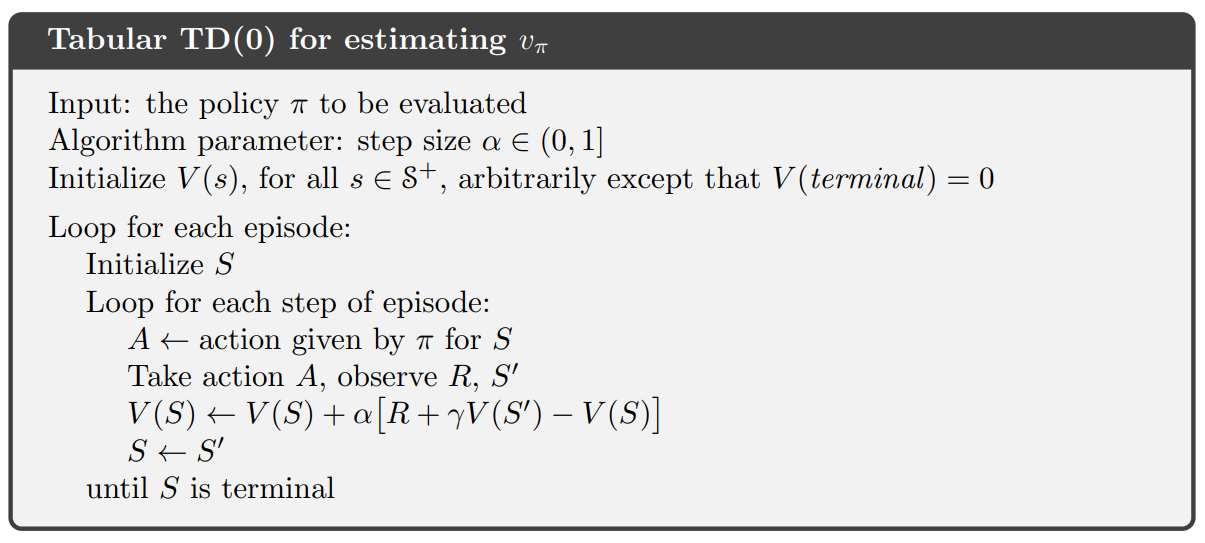

Random policy: success_rate=0.015, avg_return=0.0145


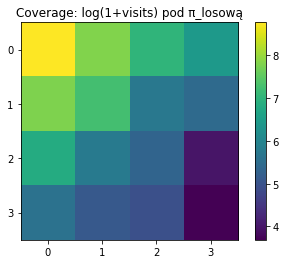

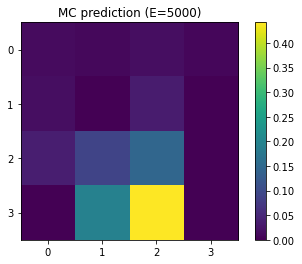

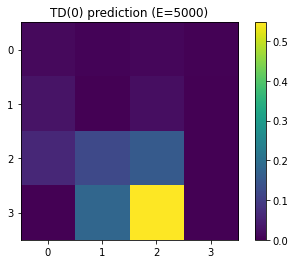

MSE MC: 4.8329922374228405e-05 | MSE TD: 0.00100457533023804


In [25]:
rng = np.random.default_rng(0)

# TODO: zdefiniuj ustaloną politykę π (np. losową).
def random_policy(s):
    # rozwiązanie: uniform random
    return int(rng.integers(0, spec.nA))

# --- Diagnostyka: czy π_losowa w ogóle "widzi" nagrodę? ---
def evaluate_policy_success(env, policy, episodes=2_000, max_steps=10_000):
    """Zwraca success_rate i średni (niezdyskontowany) return.
    W FrozenLake return ≈ sukces, bo nagroda 1 pojawia się zwykle tylko na mecie.
    """
    successes = 0
    total_returns = []
    for _ in range(episodes):
        s, _ = env.reset()
        G = 0.0
        for _ in range(max_steps):
            a = int(policy(int(s)))
            s, r, terminated, truncated, _ = env.step(a)
            G += float(r)
            if terminated or truncated:
                break
        total_returns.append(G)
        if G > 0.0:
            successes += 1
    return successes / episodes, float(np.mean(total_returns))

def state_visit_counts(env, policy, nS, episodes=2_000, max_steps=10_000):
    counts = np.zeros(nS, dtype=np.int64)
    for _ in range(episodes):
        s, _ = env.reset()
        counts[int(s)] += 1
        for _ in range(max_steps):
            a = int(policy(int(s)))
            s, r, terminated, truncated, _ = env.step(a)
            counts[int(s)] += 1
            if terminated or truncated:
                break
    return counts

sr, avg_ret = evaluate_policy_success(env, random_policy, episodes=2_000)
print(f"Random policy: success_rate={sr:.3f}, avg_return={avg_ret:.4f}")

counts = state_visit_counts(env, random_policy, nS=spec.nS, episodes=2_000)
plot_value_heatmap(np.log1p(counts).astype(np.float64), spec.shape, title="Coverage: log(1+visits) pod π_losową")

# DP baseline (model-based "prawda" do porównań)
V_dp = None
if hasattr(env, "P"):
    P_model = env.P
    pi_random = np.ones((spec.nS, spec.nA), dtype=np.float64) / spec.nA
    V_dp = policy_evaluation(P_model, pi_random, gamma=spec.gamma)

EP = 5_000

# MC vs TD(0) prediction: ten sam EP, ta sama polityka, ten sam świat.
V_mc, _ = mc_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, episodes=EP)
V_td = td0_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=0.1, episodes=EP)

plot_value_heatmap(V_mc, spec.shape, title=f"MC prediction (E={EP})")
plot_value_heatmap(V_td, spec.shape, title=f"TD(0) prediction (E={EP})")

if V_dp is not None:
    mse_mc = float(np.mean((V_mc - V_dp)**2))
    mse_td = float(np.mean((V_td - V_dp)**2))
    print("MSE MC:", mse_mc, "| MSE TD:", mse_td)


## 1b) Wczesny reżim uczenia: gdzie TD(0) może się różnić od MC?

Najczęściej różnice MC↔TD(0) widać **na małej liczbie epizodów** (zanim oba podejścia „dogonią” podobny kształt $V$).

Poniżej robimy szybkie snapshoty dla małych budżetów.

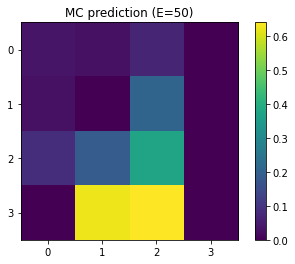

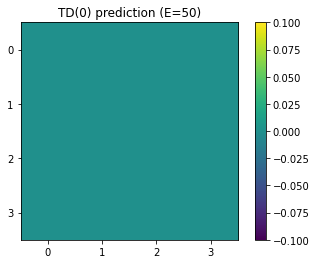

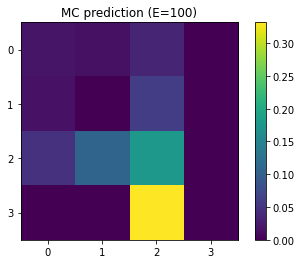

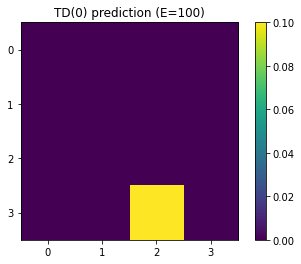

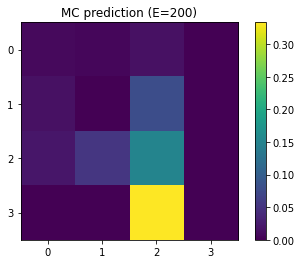

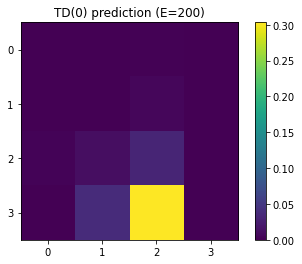

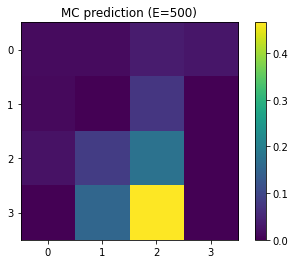

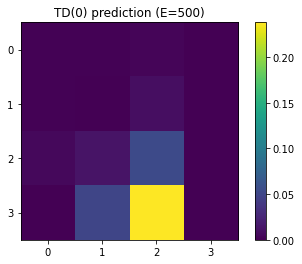

In [29]:
SMALL_EPS = [50, 100, 200, 500]
for E in SMALL_EPS:
    V_mc_E, _ = mc_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, episodes=E)
    V_td_E = td0_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=0.1, episodes=E)
    plot_value_heatmap(V_mc_E, spec.shape, title=f"MC prediction (E={E})")
    plot_value_heatmap(V_td_E, spec.shape, title=f"TD(0) prediction (E={E})")


## 2) Zbieżność: MC vs TD(0) przy rosnącym budżecie

### a)  Przykładowe  porównanie - wczesny skok.

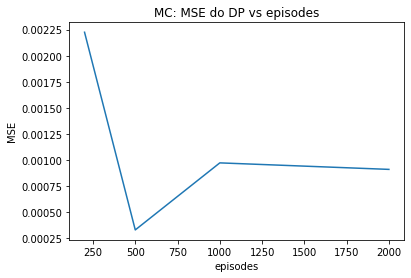

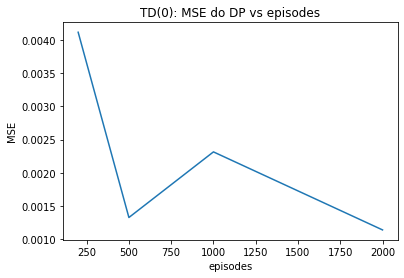

In [31]:
EP_LIST = [200, 500, 1_000, 2_000]
mse_mc, mse_td = [], []
for E in EP_LIST:
    V_mc_E, _ = mc_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, episodes=E)
    V_td_E = td0_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=0.1, episodes=E)
    if V_dp is not None:
        mse_mc.append(float(np.mean((V_mc_E - V_dp)**2)))
        mse_td.append(float(np.mean((V_td_E - V_dp)**2)))

if V_dp is not None:
    plot_learning_curve(EP_LIST, mse_mc, title="MC: MSE do DP vs episodes", xlabel="episodes", ylabel="MSE")
    plot_learning_curve(EP_LIST, mse_td, title="TD(0): MSE do DP vs episodes", xlabel="episodes", ylabel="MSE")
else:
    print("Brak DP baseline → zamiast tego porównuj mapy jakościowo.")

### b) Porównanie (ładne) zbieżności: MSE do DP vs liczba epizodów (MC vs TD(0)).

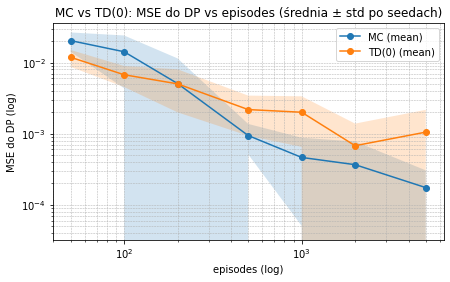

In [32]:
# Porównanie zbieżności: MSE do DP vs liczba epizodów (MC vs TD(0)).

EP_LIST = [50, 100, 200, 500, 1_000, 2_000, 5_000]
SEEDS = [0, 1, 2, 3, 4]

def make_env(seed: int):
    # budujemy to samo MDP, ale z innym seedem losowania przejść (ważne przy SLIPPERY=True)
    env_i = PModelEnv(P, start_state=s0, seed=seed, desc=desc_arr)
    env_i.nrow, env_i.ncol, env_i.desc = nrow, ncol, desc_arr
    return env_i

if V_dp is None:
    print("Brak DP baseline → zamiast MSE rób porównania jakościowe (mapy + success_rate).")
else:
    mse_mc_runs = []
    mse_td_runs = []

    for seed in SEEDS:
        mse_mc = []
        mse_td = []
        for E in EP_LIST:
            env_i = make_env(seed)
            rng_i = np.random.default_rng(seed)

            def pi_rand(s, rng=rng_i):
                return int(rng.integers(0, spec.nA))

            V_mc_E, _ = mc_prediction(env_i, pi_rand, nS=spec.nS, gamma=spec.gamma, episodes=E)
            V_td_E = td0_prediction(env_i, pi_rand, nS=spec.nS, gamma=spec.gamma, alpha=0.1, episodes=E)

            mse_mc.append(float(np.mean((V_mc_E - V_dp) ** 2)))
            mse_td.append(float(np.mean((V_td_E - V_dp) ** 2)))

        mse_mc_runs.append(mse_mc)
        mse_td_runs.append(mse_td)

    mse_mc_runs = np.array(mse_mc_runs, dtype=np.float64)
    mse_td_runs = np.array(mse_td_runs, dtype=np.float64)

    mc_mean, mc_std = mse_mc_runs.mean(axis=0), mse_mc_runs.std(axis=0)
    td_mean, td_std = mse_td_runs.mean(axis=0), mse_td_runs.std(axis=0)

    plt.figure(figsize=(7, 4))
    plt.plot(EP_LIST, mc_mean, marker="o", label="MC (mean)")
    plt.fill_between(EP_LIST, mc_mean - mc_std, mc_mean + mc_std, alpha=0.2)

    plt.plot(EP_LIST, td_mean, marker="o", label="TD(0) (mean)")
    plt.fill_between(EP_LIST, td_mean - td_std, td_mean + td_std, alpha=0.2)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("episodes (log)")
    plt.ylabel("MSE do DP (log)")
    plt.title("MC vs TD(0): MSE do DP vs episodes (średnia ± std po seedach)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()


## 3) Preview: SARSA vs Q-learning (kontrola)

**On-policy (SARSA)**: w update używamy akcji, którą agent *naprawdę wybiera* w następnym stanie (np. $\epsilon$-greedy). Czyli uczymy się wartości dla tej samej polityki, którą aktualnie wykonujemy, więc eksploracja jest “wliczona” w target. W praktyce oznacza to, że jeśli agent czasem zrobi losowy (gorszy) ruch, SARSA uczy się polityki, która nadal działa sensownie mimo takiej eksploracji.

**Off-policy (Q-learning)**: w update nie używamy akcji faktycznie wybranej w następnym stanie, tylko zakładamy najlepszy możliwy ruch przez $\max_a Q(S',a)$. Czyli agent może eksplorować jedną polityką, ale uczy się wartości dla polityki zachłannej (optymalnej). W praktyce oznacza to, że Q-learning “uczy się jakby” od następnego kroku zawsze wybierał najlepszą akcję, nawet jeśli podczas treningu czasem wybiera losowo.


W prediction (MC/TD(0)) oceniamy **daną** politykę $\pi$ i uczymy $V^\pi(s)$.
W kontroli (control) chcemy politykę **ulepszać**, więc wygodniej jest uczyć **wartości akcji**:

$$
Q^\pi(s,a)=\mathbb{E}_\pi[G_t\mid S_t=s,\ A_t=a],
\qquad
\pi_{\text{greedy}}(s)=\arg\max_a Q(s,a).
$$

To jest główny krok “teoretyczny”: przejście z $V$ do $Q$, bo wtedy *improvement* jest natychmiastowe.

### SARSA (on-policy TD control)

**Idea:** uczymy $Q$ dla polityki, którą **naprawdę wykonujemy** (zwykle $\epsilon$-greedy względem $Q$).  
Nazwa SARSA pochodzi od sekwencji $(S,A,R,S',A')$ używanej w aktualizacji.

Aktualizacja (TD error dla $Q$):

$$
\delta_t
=
R_{t+1}+\gamma Q(S_{t+1},A_{t+1})-Q(S_t,A_t),
\qquad
Q(S_t,A_t)\leftarrow Q(S_t,A_t)+\alpha\,\delta_t.
$$

**Co to znaczy on-policy?**  
Target używa **tej samej** polityki, która generuje dane (bo $A_{t+1}$ jest wybrane $\epsilon$-greedy z aktualnego $Q$).

**Czego się spodziewać (intuicja):**
- w środowiskach ryzykownych / stochastycznych (np. FrozenLake `slippery=True`) SARSA bywa bardziej “ostrożna”,
  bo aktualizuje wartości zgodnie z zachowaniem polityki, która *czasem popełnia* losowe ruchy (eksploracja).
- jeśli $\epsilon$ nie maleje, to uczymy politykę optymalną **dla $\epsilon$-greedy**, a nie dla czysto zachłannej.

### Q-learning (off-policy TD control)

**Idea:** uczymy $Q \approx q_\*$, czyli wartości dla polityki optymalnej, nawet jeśli zachowanie jest eksploracyjne.  
Zachowanie: wybieramy akcje np. $\epsilon$-greedy, żeby zbierać dane.  
Target: traktujemy kolejny stan tak, jakbyśmy zawsze wybierali najlepszą akcję.

Aktualizacja:

$$
\delta_t
=
R_{t+1}+\gamma \max_a Q(S_{t+1},a)-Q(S_t,A_t),
\qquad
Q(S_t,A_t)\leftarrow Q(S_t,A_t)+\alpha\,\delta_t.
$$

**Co to znaczy off-policy?**  
Target zakłada politykę zachłanną (max), a dane mogą pochodzić z innej polityki (np. $\epsilon$-greedy).

**Czego się spodziewać (intuicja):**
- często szybciej “pcha” do zachłannej polityki i wyższych wartości $\max_a Q$,
- bywa bardziej “agresywny” (w FrozenLake może preferować ryzykowne skróty),
- ma znany problem **overestimation bias** (maksimum zawyża), co motywuje **Double Q-learning** w kolejnych ćwiczeniach.

---

### Najważniejsze różnice vs wcześniejsze metody (MC / TD(0) prediction)

1) **Cel uczenia:**  
   - wcześniej: $V^\pi$ dla ustalonej $\pi$ (evaluation),  
   - teraz: $Q$ + poprawa polityki przez $\epsilon$-greedy / max (control).

2) **Bootstrapping zostaje, ale przechodzimy z $V$ na $Q$:**
   - TD(0): $r+\gamma V(s')$  
   - SARSA: $r+\gamma Q(s',a')$  
   - Q-learning: $r+\gamma \max_a Q(s',a)$

3) **On-policy vs off-policy:**
   - SARSA: target zależy od akcji faktycznie wybranej ($A'$),  
   - Q-learning: target zależy od najlepszego możliwego ruchu (max), niezależnie od tego, co wykonaliśmy.

W tym bloku celem jest:
- zobaczyć aktualizacje,
- złapać różnicę on/off-policy,
- i mieć intuicję pod późniejsze metody typu Actor–Critic/PPO (gdzie zwykle mamy politykę $\pi_\theta$ i estymator wartości jako “krytyka”).


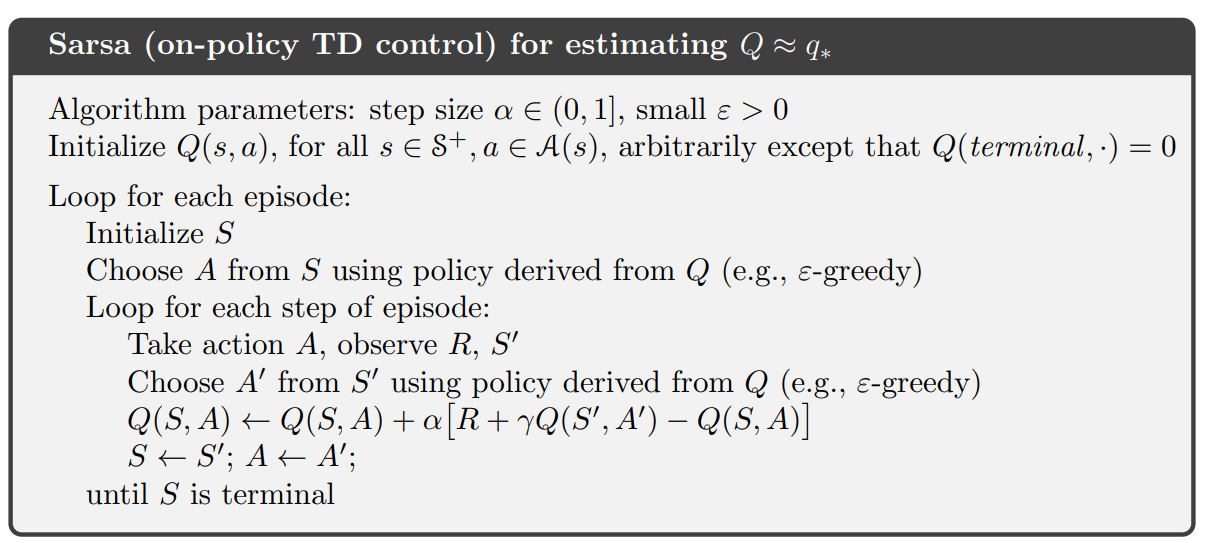

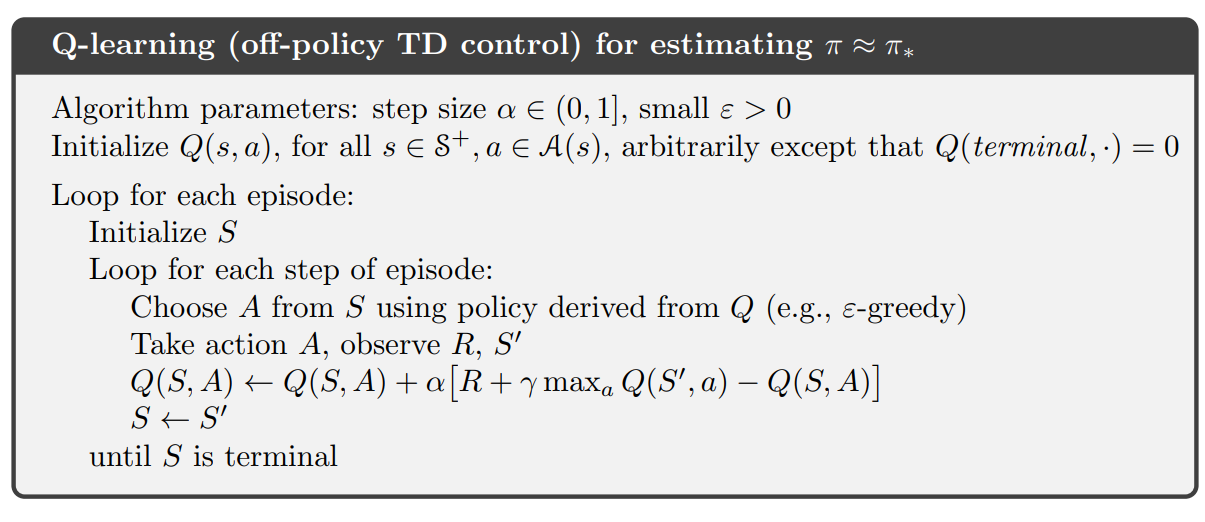

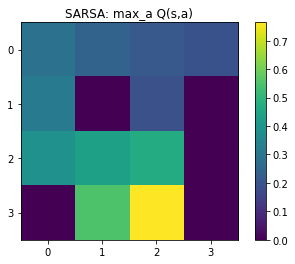

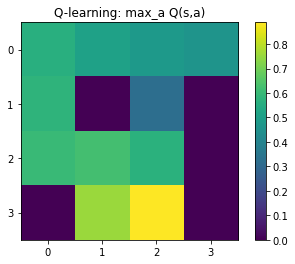

Greedy policy success_rate: SARSA=0.618, Q-learning=0.824


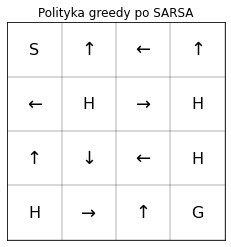

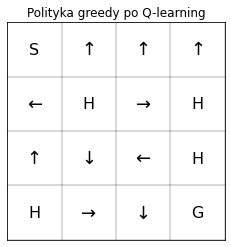

In [34]:
Q_sarsa, pi_sarsa = sarsa(env, nS=spec.nS, nA=spec.nA, gamma=spec.gamma, alpha=0.1, epsilon=0.1, episodes=20_000, seed=0)
Q_ql, pi_ql = q_learning(env, nS=spec.nS, nA=spec.nA, gamma=spec.gamma, alpha=0.1, epsilon=0.1, episodes=20_000, seed=0)

plot_value_heatmap(np.max(Q_sarsa, axis=1), spec.shape, title="SARSA: max_a Q(s,a)")
plot_value_heatmap(np.max(Q_ql, axis=1), spec.shape, title="Q-learning: max_a Q(s,a)")

# --- Dydaktycznie ważne: pokaż też gotową politykę (strzałki) i success-rate ---
def plot_policy_arrows(pi, shape, desc=None, title="Policy (arrows)"):
    arrow = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    nrow, ncol = shape
    pi_grid = np.array(pi, dtype=int).reshape(nrow, ncol)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(np.zeros((nrow, ncol)), alpha=0.0)

    # siatka
    for r in range(nrow + 1):
        ax.axhline(r - 0.5, color="black", linewidth=0.3)
    for c in range(ncol + 1):
        ax.axvline(c - 0.5, color="black", linewidth=0.3)

    for r in range(nrow):
        for c in range(ncol):
            ch = None
            if desc is not None:
                ch = desc[r][c]
                # desc bywa w bytes → zamień na str
                if isinstance(ch, (bytes, np.bytes_)):
                    ch = ch.decode("utf-8")
            if ch in ["H", "G", "S"]:
                ax.text(c, r, ch, ha="center", va="center", fontsize=16)
            else:
                ax.text(c, r, arrow[int(pi_grid[r, c])], ha="center", va="center", fontsize=18)

    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

# success rate greedy-policy (bez ε, tylko argmax)
def pi_from_array(pi_arr):
    return lambda s: int(pi_arr[int(s)])

sr_sarsa, _ = evaluate_policy_success(env, pi_from_array(pi_sarsa), episodes=2_000)
sr_ql, _ = evaluate_policy_success(env, pi_from_array(pi_ql), episodes=2_000)
print(f"Greedy policy success_rate: SARSA={sr_sarsa:.3f}, Q-learning={sr_ql:.3f}")

plot_policy_arrows(pi_sarsa, spec.shape, desc=spec.desc, title="Polityka greedy po SARSA")
plot_policy_arrows(pi_ql, spec.shape, desc=spec.desc, title="Polityka greedy po Q-learning")


## (Opcjonalnie/zabawowo) Reward shaping – widać różnice, ale to *inna* definicja nagrody

Często podaje się:
- małą karę za każdy krok (np. -0.001), żeby sygnał był gęstszy,
- większą karę za wpadnięcie do dziury,
- karę za “stanie w miejscu” (uderzanie w ścianę).

To przyspiesza uczenie i **uwidacznia różnice** między algorytmami, ale pamiętaj: to zmienia problem (inny MDP / inna funkcja celu).

In [36]:
# Wrapper do modyfikacji nagrody (reward shaping) – inspirowane zewnętrznym kursem.
class ShapedRewardWrapper:
    def __init__(self, env, step_penalty=-0.001, hole_penalty=-1.0, stay_penalty=-1.0):
        self.env = env
        self.step_penalty = float(step_penalty)
        self.hole_penalty = float(hole_penalty)
        self.stay_penalty = float(stay_penalty)
        # proxy atrybutów
        for k in ["nrow", "ncol", "desc", "P"]:
            if hasattr(env, k):
                setattr(self, k, getattr(env, k))
    def reset(self, *args, **kwargs):
        return self.env.reset(*args, **kwargs)
    def step(self, a):
        s_prev = getattr(self.env, "s", None)
        sp, r, terminated, truncated, info = self.env.step(a)
        # krok bez nagrody → mała kara (gęstszy sygnał)
        if (not (terminated or truncated)) and float(r) == 0.0:
            r = self.step_penalty
        # terminal bez nagrody → dziura → większa kara
        if (terminated or truncated) and float(r) == 0.0:
            r = self.hole_penalty
        # brak ruchu (często ściana) → kara
        try:
            if int(sp) == int(s_prev) and (not (terminated or truncated)):
                r = self.stay_penalty
        except Exception:
            pass
        return sp, r, terminated, truncated, info

# Przykład użycia:
# env_shaped = ShapedRewardWrapper(make_env(seed=0))
# V_td_shaped = td0_prediction(env_shaped, random_policy, nS=spec.nS, gamma=spec.gamma, alpha=0.1, episodes=2_000)
# plot_value_heatmap(V_td_shaped, spec.shape, title="TD(0) na shaped reward (demo)")


## Ćwiczenia (na zajęcia)

1) **Wpływ kroku uczenia $\alpha$**  
   - Ustaw `alpha` w TD(0): 0.05, 0.1, 0.5.  
   - Pytanie: kiedy TD zaczyna „tańczyć” (niestabilność)?

2) **On-policy vs off-policy**  
   - Porównaj SARSA (on-policy) i Q-learning (off-policy) na `SLIPPERY=True`.  
   - Pytanie: czemu SARSA bywa „ostrożniejsza” w środowiskach ryzykownych?

3) **Cena bootstrappingu**  
   - Zwiększ epizody do np. 50k. Czy TD(0) i MC w końcu wyglądają podobnie?  
   - Można też spróbować zmniejszać ilość epizodów, aby zobaczyć, jak poszczególne metody zachowują się wraz
     ze zmniejszaniem się epizodów (ustawić pośrednią liczbę, gdzie widać wyraźne różnice między metodami).       Dotyczy wszystkich powyższych
   - Dyskusja: skąd bierze się bias w TD?

4) **Mini‑zadanie (5 min)**  
   - TODO: zmień politykę z losowej na „zawsze RIGHT” (akcja 2 w FrozenLake).  
   - Sprawdź, jak zmienia się $V^\pi$ w DP/MC/TD.